# Epidemiology of SARS-CoV-2

Reference:  
Kissler et al. "Projecting the transmission dynamics of SARS-CoV-2 through the postpandemic period." Science 368.6493 (2020): 860.

## SEIR model of COVID-19

Our SEIR (susceptible-exposed-infected-recovered) model is defined by the following differential equations:
\begin{align}
\frac{dS}{dt} &= -\frac{\beta \left( I_R + I_H \right) S}{N}\\
\frac{dE}{dt} &= \frac{\beta \left( I_R + I_H \right) S}{N} - \nu E\\
\frac{dI_R}{dt} &= p_R \nu E -\gamma I_R\\
\frac{dI_H}{dt} &= p_H \nu E -\gamma I_H\\
\frac{dR}{dt} &= \gamma I_R + \epsilon H\\
\frac{dH}{dt} &= \gamma I_H - \epsilon H
\end{align}
with the following default parameters (in the absence of measures):
\begin{align}
\beta &= 0.50 \text{ days}^{-1} \\
\nu &= 0.22 \text{ days}^{-1} \\
\gamma &= 0.20 \text{ days}^{-1} \\
\epsilon &= 0.10 \text{ days}^{-1} \\
p_H &= 0.013 \\
p_R &= 0.987
\end{align}

These are the effects of measures on the parameters of the model:
- Full lockdown reduces $\beta$ by 85% ($\beta \rightarrow 0.15\beta$)
- Social distancing reduces $\beta$ by 45% ($\beta \rightarrow 0.55\beta$)
- Personal protection reduces $\beta$ by 20% ($\beta \rightarrow 0.8\beta$)
- Extensive tracking and testing increases $\gamma$ by a factor of 2 ($\gamma \rightarrow 2\gamma$), but this is only possible if the number of exposed individuals is lower than 100 (since tracking and testing requires resourses that are limited, e.g., PCR kits and contact tracers)

Various measures can be combined (e.g. $\beta$(social distancing+protection)=0.5 x 0.55 x 0.8), but you cannot combine social distancing and lockdown together (only pick one of the two).

In [102]:
# load libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Task 1 - Implementing the SEIR model:

#### Step A.

Define a function `run_simulation_epidemic` which takes as input:  
- the set of lists containing the past histories of susceptible, exposed, infected ($I_R$ or $I_H$), recovered and hospitalized number of people every day
- the parameters of the SEIR model (by default, set as above)
- the maximum number of days over which you want to run the simulation

and gives as output:
- the set of lists containing the histories of susceptible, exposed, infected (R or H), recovered and hospitalized number of people every day obtained from the simulation, appended to the past histories given as input (so that we don't loose the past data, this is useful to cobine multiple simulations with different parameters together)

The timestep of the simulation should be kept fixed so that the simulation is broken down in Nday=100 steps for each day. Data should be appended to the lists daily, so once every Nday=100 steps of the simulations.

As done in earliers projects, the simulation function should make use of another function that computes the derivatives of the model given the current variables and model parameters.

In [103]:
def derivatives_epidemic(s,e,ir,ih,r,h, \
                         beta,nu,N,gamma,epsilon, \
                         PH,PR):
    # compute derivatives based on variables and model parameters
    d_s = -(beta*(ir+ih)*s)/N
    d_e = ((beta*(ir+ih)*s)/N)-nu*e
    d_ir = PR*nu*e-gamma*ir
    d_ih=PH*nu*e-gamma*ih
    d_r = gamma*ir + epsilon*h
    d_h = gamma*ih - epsilon*h
    
    return d_s,d_e,d_ir,d_ih,d_r,d_h

In [104]:
# define simulation for SEIR model
def run_simulation_epidemic(S0,E0,IR0,IH0,R0,H0, beta=0.50,nu=0.22,gamma=0.20,epsilon=0.1, PH=0.013,PR=0.987, Tmax=730): # simulate for 2 years, before vaccine becomes available
    # initialize the lists for the histories of the susceptible, exposed, infected (R or H), recovered and hospitalized
    # we indicate with uppercase letters list of variables and with lowercase letters the current variables
    # we create new lists equal to those given as input, so that the input is not modified
    S =list(S0)
    E =list(E0)
    IR=list(IR0)
    IH=list(IH0)
    R =list(R0)
    H =list(H0)
    
    # simulation settings
    Nday=100 # number of simulation steps in one day
    dt=1./Nday # timestep, 0.01 days
    Nsteps=int(Tmax)*Nday # total number of simulation steps
    # setup current variables
    s =S[-1]  # last number of susceptible individuals
    e =E[-1]  # last number of exposed individuals
    ir=IR[-1] # last number of infected (recovering) individuals
    ih=IH[-1] # last number of infected (in need of critical care) individuals
    r =R[-1]  # last number of recovered individuals
    h =H[-1]  # last number of hospitalized individuals
    N =s+e+ir+ih+r+h # total population size
    
    # Here loop over the simulation 
    for i in range(Nsteps):
        # Compute derivatives using the function defined above
        d_s,d_e,d_ir,d_ih,d_r,d_h = derivatives_epidemic(s,e,ir,ih,r,h,beta,nu,N,gamma,epsilon,PH,PR)
        
        # Here implements the Euler algorithm for the model
        s += d_s*dt
        e += d_e*dt
        ir += d_ir*dt
        ih += d_ih*dt
        r += d_r*dt
        h += d_h*dt
        # Here saves daily data to the history lists every Nday steps (if step%Nday==0)
        if i%Nday == 0: 
            S.append(s)
            E.append(e)
            IR.append(ir)
            IH.append(ih)
            R.append(r)
            H.append(h)
                
    # return the complete history
    return S,E,IR,IH,R,H

#### Step B.

You should also define a `plot_epidemic` function that takes as input:
- the set of lists containing the past histories of susceptible, exposed, infected (R or H), recovered and hospitalized number of people every day

and creates 3 panels stacked vertically on top of each other, containing the following information for each graph as a function of time:
1. the number of susceptible and recovered people each day
2. the number of exposed and infected (total H+R) people for each day
3. the number of hospitalized people each day

The plot should be generated using the function `subplots` from matplotlib, and should return the fig and axes objects from subplots, so that these can be used later to add information to your plot. You may also modify this function to add useful information such as the maximum hospital capacity (70 in our scanarios) in the last panel, and the expected herd immunity level in the first panel. The plots should have all the appropriate labels, and each curve should have its own distinguishable style. Please refer to the online matplotlib documentation (<https://matplotlib.org/>) for more info.

In [213]:
def plot_epidemic(S,E,IR,IH,R,H):
    fig,(ax1,ax2,ax3)=plt.subplots(3,1,sharex='all',dpi=600)
    fig.set_facecolor('white')
    # the ax1, ax2, and ax3 objects can be used to make graphs in the corresponding panel
    # for example
    ax1.plot(S,linestyle='-',color='cyan',label='susceptible')
    ax1.plot(R,linestyle='-',color='green',label='recovered')
    beta = .5
    gamma = .2
    R0 = beta/gamma
    herd_p =(1 - 1/R0)
    herd = (S[0]+E[0]+IR[0]+IH[0]+R[0]+H[0])*herd_p
    print('Herd Immunity Percentage: '+str(herd_p))
    print('Herd Immunity: '+str(herd))
    ax1.axhline(y = herd, color = 'r', linestyle = '-',label='herd immunity reached')
    ax2.plot(E,linestyle='-',color='orange',label='exposed')
    IR = np.array(IR)
    IH = np.array(IH)
    ax2.plot(IR+IH,linestyle='-',color='red',label='infected')
    ax3.plot(H,linestyle='-',color='blue',label='hospitalized')
    ax3.axhline(y = 50, color = 'r', linestyle = '-',label='hospital capacity')
    ax3.axhline(y = 25, color = 'grey', linestyle = '-',label='hospital 50 percent capacity')
    ax3.axhline(y = 50*.3, color = 'black', linestyle = '-',label='hospital 30 percent capacity')
    # TODO: fill all the panels with the correct information
    # finally add the legends
    ax1.set_xlabel('days')
    ax1.set_ylabel('people')
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    '''
    from matplotlib.patches import Rectangle
    rec1=Rectangle((100,0),50,1e6,alpha=0.5,facecolor='grey')
    ax1.add_patch(rec1)
    '''
    # return axes so that you can add things to the plot
    return fig,ax1,ax2,ax3

To make your plots more clear, you may highlight regions with different kinds of measures using rectangular shades. For example a rectangle starting at day 50 and 0 people with sides of length 200 days and 20000 people may be drawn on the first figure panel using:
```python
from matplotlib.patches import Rectangle
rec1=Rectangle((50,0),200,20000,alpha=0.5,facecolor='grey')
ax1.add_patch(rec1)
```

#### Step C.

Perform a simulation of an epidemic that started in a region with a population of 1 million people. Initially, there is only one person that is exposed to the virus, whereas all the rest of the population is susceptible and no-one is infected, hospitalized or recovered.

In [106]:
# these are your initial conditions to pass to the function run_simulation_epidemic
S0 =[999999.]
E0 =[1.]
IR0=[0.]
IH0=[0.]
R0= [0.]
H0= [0.]
S,E,IR,IH,R,H = run_simulation_epidemic(S0,E0,IR0,IH0,R0,H0)

Herd Immunity Percentage: 0.6
Herd Immunity: 600000.0


(<Figure size 432x288 with 3 Axes>,
 <AxesSubplot:xlabel='days', ylabel='people'>,
 <AxesSubplot:>,
 <AxesSubplot:>)

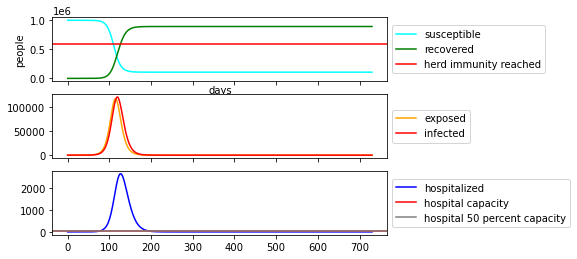

In [107]:
plot_epidemic(S,E,IR,IH,R,H)

Authorities in the considered regions do not realize of the rapid spread of the virus and do not take any preventive measure for the next 70 days since the first exposure. Your task is to simulate the course of the epidemic over the first 70 days, you should use the default parameters of the model for COVID-19. Finally, plot your results using the function defined in step B.

### Task 2 - Designing policies to control an advanced stage epidemic:

Starting from the histories of the population simulated in the previous step, consider now what happens to the course of the epidemic under various policies designed to limit the spread of the epidemic. 

First, design one or more social distancing policies that will ensure to contain the epidemic for 2 years to make sure that hospitalizations remain below the maximum capacity (50 in this region) while possibly not disrupting too much people's lives. It may be useful to change the measures depending on the number of hospitalizations, so that restrictions can be lifted when there is little risk, and reinstated when the conditions deteriorate again. When considering measures that change as a function of time, do not write a new simulation function that both implements your algorithm and your pandemic strategy. Instead, it is convenient to simply repeatidly call the originally defined `run_simulation_epidemic` function using different parameters (which may change depending on the conditions), and append the new simulation history to the past one. For example:

In [108]:
S0 =[999999.]
E0 =[1.]
IR0=[0.]
IH0=[0.]
R0= [0.]
H0= [0.]
# history of the first 70 days 
S,E,IR,IH,R,H=run_simulation_epidemic(S0,E0,IR0,IH0,R0,H0,Tmax=70)
# use the past history as input, apply some measure for a month, and append new history to past one
beta_lockdown=0.15*0.5
S,E,IR,IH,R,H=run_simulation_epidemic(S,E,IR,IH,R,H,beta=beta_lockdown,Tmax=660)
# S,E,IR,IH,R,H will contain the data for both the initial 70 days without measure and the next 30 days with lockdown

Herd Immunity Percentage: 0.6
Herd Immunity: 600000.0


(<Figure size 432x288 with 3 Axes>,
 <AxesSubplot:xlabel='days', ylabel='people'>,
 <AxesSubplot:>,
 <AxesSubplot:>)

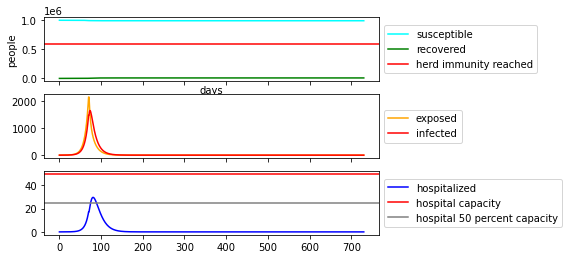

In [109]:
plot_epidemic(S,E,IR,IH,R,H)

Herd Immunity Percentage: 0.6
Herd Immunity: 600000.0


(<Figure size 432x288 with 3 Axes>,
 <AxesSubplot:xlabel='days', ylabel='people'>,
 <AxesSubplot:>,
 <AxesSubplot:>)

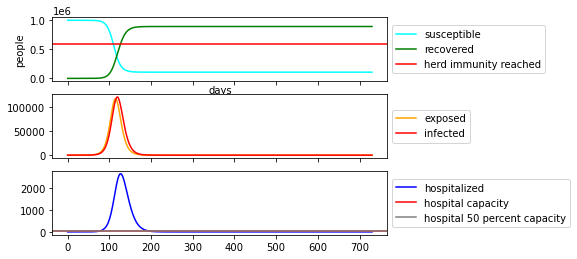

In [110]:
S0 =[999999.]
E0 =[1.]
IR0=[0.]
IH0=[0.]
R0= [0.]
H0= [0.]
# history of the first 70 days 
S,E,IR,IH,R,H=run_simulation_epidemic(S0,E0,IR0,IH0,R0,H0,Tmax=730)
plot_epidemic(S,E,IR,IH,R,H)

In [111]:
# define simulation for SEIR model
# Reduces beta based on preventative measure when hospitalization reaches 50 percent capacity
def run_simulation_epidemic_RWH(S0,E0,IR0,IH0,R0,H0, beta=0.50,nu=0.22,gamma=0.20,epsilon=0.1, PH=0.013,PR=0.987, Tmax=730): # simulate for 2 years, before vaccine becomes available
    # initialize the lists for the histories of the susceptible, exposed, infected (R or H), recovered and hospitalized
    # we indicate with uppercase letters list of variables and with lowercase letters the current variables
    # we create new lists equal to those given as input, so that the input is not modified
    S =list(S0)
    E =list(E0)
    IR=list(IR0)
    IH=list(IH0)
    R =list(R0)
    H =list(H0)
    
    # simulation settings
    Nday=100 # number of simulation steps in one day
    dt=1./Nday # timestep, 0.01 days
    Nsteps=int(Tmax)*Nday # total number of simulation steps
    # setup current variables
    s =S[-1]  # last number of susceptible individuals
    e =E[-1]  # last number of exposed individuals
    ir=IR[-1] # last number of infected (recovering) individuals
    ih=IH[-1] # last number of infected (in need of critical care) individuals
    r =R[-1]  # last number of recovered individuals
    h =H[-1]  # last number of hospitalized individuals
    N =s+e+ir+ih+r+h # total population size
    
    # TODO: here loop over the simulation 
    for i in range(Nsteps):
        # TODO: compute derivatives using the function defined above
        
            
        d_s,d_e,d_ir,d_ih,d_r,d_h =  derivatives_epidemic(s,e,ir,ih,r,h,beta,nu,N,gamma,epsilon,PH,PR) if H[-1] < 50*.5 else derivatives_epidemic(s,e,ir,ih,r,h,.15*beta,nu,N,gamma,epsilon,PH,PR)
        
        # TODO: here implement the Euler algorithm for the model
        s += d_s*dt
        e += d_e*dt
        ir += d_ir*dt
        ih += d_ih*dt
        r += d_r*dt
        h += d_h*dt
        # TODO: here save daily data to the history lists every Nday steps (if step%Nday==0)
        '''
        S.append(s)
        E.append(e)
        IR.append(ir)
        IH.append(ih)
        R.append(r)
        H.append(h)
        '''
        #'''
        if i%Nday == 0: 
            S.append(s)
            E.append(e)
            IR.append(ir)
            IH.append(ih)
            R.append(r)
            H.append(h)
        #'''        
    # return the complete history
    return S,E,IR,IH,R,H

Herd Immunity Percentage: 0.6
Herd Immunity: 600000.0


(<Figure size 432x288 with 3 Axes>,
 <AxesSubplot:xlabel='days', ylabel='people'>,
 <AxesSubplot:>,
 <AxesSubplot:>)

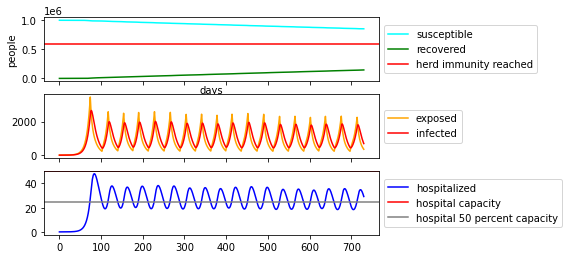

In [112]:
S0 =[999999.]
E0 =[1.]
IR0=[0.]
IH0=[0.]
R0= [0.]
H0= [0.]
# history of the first 70 days 
S,E,IR,IH,R,H=run_simulation_epidemic_RWH(S0,E0,IR0,IH0,R0,H0,Tmax=730)
plot_epidemic(S,E,IR,IH,R,H)

In [208]:
# define simulation for SEIR model
# If hospital reaches 50% then perform contact tracing+social distancing+PPE, if drops below 30% then stop contact tracing, then continue with just social distancing and PPE
def run_simulation_epidemic_CSP(S0,E0,IR0,IH0,R0,H0, beta=0.50,nu=0.22,gamma=0.20,epsilon=0.1, PH=0.013,PR=0.987, Tmax=730,measures=False): # simulate for 2 years, before vaccine becomes available
    # initialize the lists for the histories of the susceptible, exposed, infected (R or H), recovered and hospitalized
    # we indicate with uppercase letters list of variables and with lowercase letters the current variables
    # we create new lists equal to those given as input, so that the input is not modified
    S =list(S0)
    E =list(E0)
    IR=list(IR0)
    IH=list(IH0)
    R =list(R0)
    H =list(H0)
    
    # simulation settings
    Nday=100 # number of simulation steps in one day
    dt=1./Nday # timestep, 0.01 days
    Nsteps=int(Tmax)*Nday # total number of simulation steps
    # setup current variables
    s =S[-1]  # last number of susceptible individuals
    e =E[-1]  # last number of exposed individuals
    ir=IR[-1] # last number of infected (recovering) individuals
    ih=IH[-1] # last number of infected (in need of critical care) individuals
    r =R[-1]  # last number of recovered individuals
    h =H[-1]  # last number of hospitalized individuals
    N =s+e+ir+ih+r+h # total population size
    m_cnt = 0
    nm_cnt = 0
    # Here loops over the simulation 
    for i in range(Nsteps):
        # Computes derivatives using the function defined above
        if H[-1] >= 50*.5:
            measures = True
            
        if measures and H[-1] < 50*.3:
            measures = False
        d_s,d_e,d_ir,d_ih,d_r,d_h = 0,0,0,0,0,0
        if not measures:
             d_s,d_e,d_ir,d_ih,d_r,d_h = derivatives_epidemic(s,e,ir,ih,r,h,.8*.55*beta,nu,N,gamma,epsilon,PH,PR)  
        else:
            d_s,d_e,d_ir,d_ih,d_r,d_h = derivatives_epidemic(s,e,ir,ih,r,h,.55*.8*beta,nu,N,2*gamma,epsilon,PH,PR)
        
        # Here implements the Euler algorithm for the model
        s += d_s*dt
        e += d_e*dt
        ir += d_ir*dt
        ih += d_ih*dt
        r += d_r*dt
        h += d_h*dt
        
        # Here saves daily data to the history lists every Nday steps (if step%Nday==0)
        if i%Nday == 0: 
            if measures:
                m_cnt+=1
            else:
                nm_cnt+=1
            S.append(s)
            E.append(e)
            IR.append(ir)
            IH.append(ih)
            R.append(r)
            H.append(h)
    print("Days with full measures: ",m_cnt)
    print("Days with just PP and social distancing: ",nm_cnt)
    return S,E,IR,IH,R,H

In [211]:
# define simulation for SEIR model
def run_simulation_epidemic_vax(S0,E0,IR0,IH0,R0,H0, beta=0.50,nu=0.22,gamma=0.20,epsilon=0.1, PH=0.013,PR=0.987, Tmax=730): # simulate for 2 years, before vaccine becomes available
    S =list(S0)
    E =list(E0)
    IR=list(IR0)
    IH=list(IH0)
    R =list(R0)
    H =list(H0)

    Nday=100 # number of simulation steps in one day
    dt=1./Nday # timestep, 0.01 days
    Nsteps=int(Tmax)*Nday # total number of simulation steps
    # setup current variables
    s =S[-1]  # last number of susceptible individuals
    e =E[-1]  # last number of exposed individuals
    ir=IR[-1] # last number of infected (recovering) individuals
    ih=IH[-1] # last number of infected (in need of critical care) individuals
    r =R[-1]  # last number of recovered individuals
    h =H[-1]  # last number of hospitalized individuals
    N =s+e+ir+ih+r+h # total population size
    cnt = 0
    # Here loops over the simulation 
    for i in range(Nsteps):
        # Computes derivatives using the function defined above
        d_s,d_e,d_ir,d_ih,d_r,d_h = derivatives_epidemic(s,e,ir,ih,r,h,beta,nu,N,gamma,epsilon,PH,PR) \
            if R[-1] >= 600000 else derivatives_epidemic(s,e,ir,ih,r,h,.8*beta,nu,N,2*gamma,epsilon,PH,PR)
        # Here implements the Euler algorithm for the 
        s += d_s*dt
        e += d_e*dt
        ir += d_ir*dt
        ih += d_ih*dt
        r -= d_r*dt
        h += d_h*dt
        # Here saves daily data to the history lists every Nday steps (if step%Nday==0)
        if i%Nday == 0: 
            if not s-r*.012 <0 and r < S[0]*.75:
                s -= r*.012
                r += r*.012
            if r < 600000:
                cnt+=1
            S.append(s)
            E.append(e)
            IR.append(ir)
            IH.append(ih)
            R.append(r)
            H.append(h)
    print("Days with just PP and contact tracing: ",cnt)
    return S,E,IR,IH,R,H

Days with full measures:  51
Days with just PP and social distancing:  244
Days with just PP and contact tracing:  240
Herd Immunity Percentage: 0.6
Herd Immunity: 600000.0


(<Figure size 3600x2400 with 3 Axes>,
 <AxesSubplot:xlabel='days', ylabel='people'>,
 <AxesSubplot:>,
 <AxesSubplot:>)

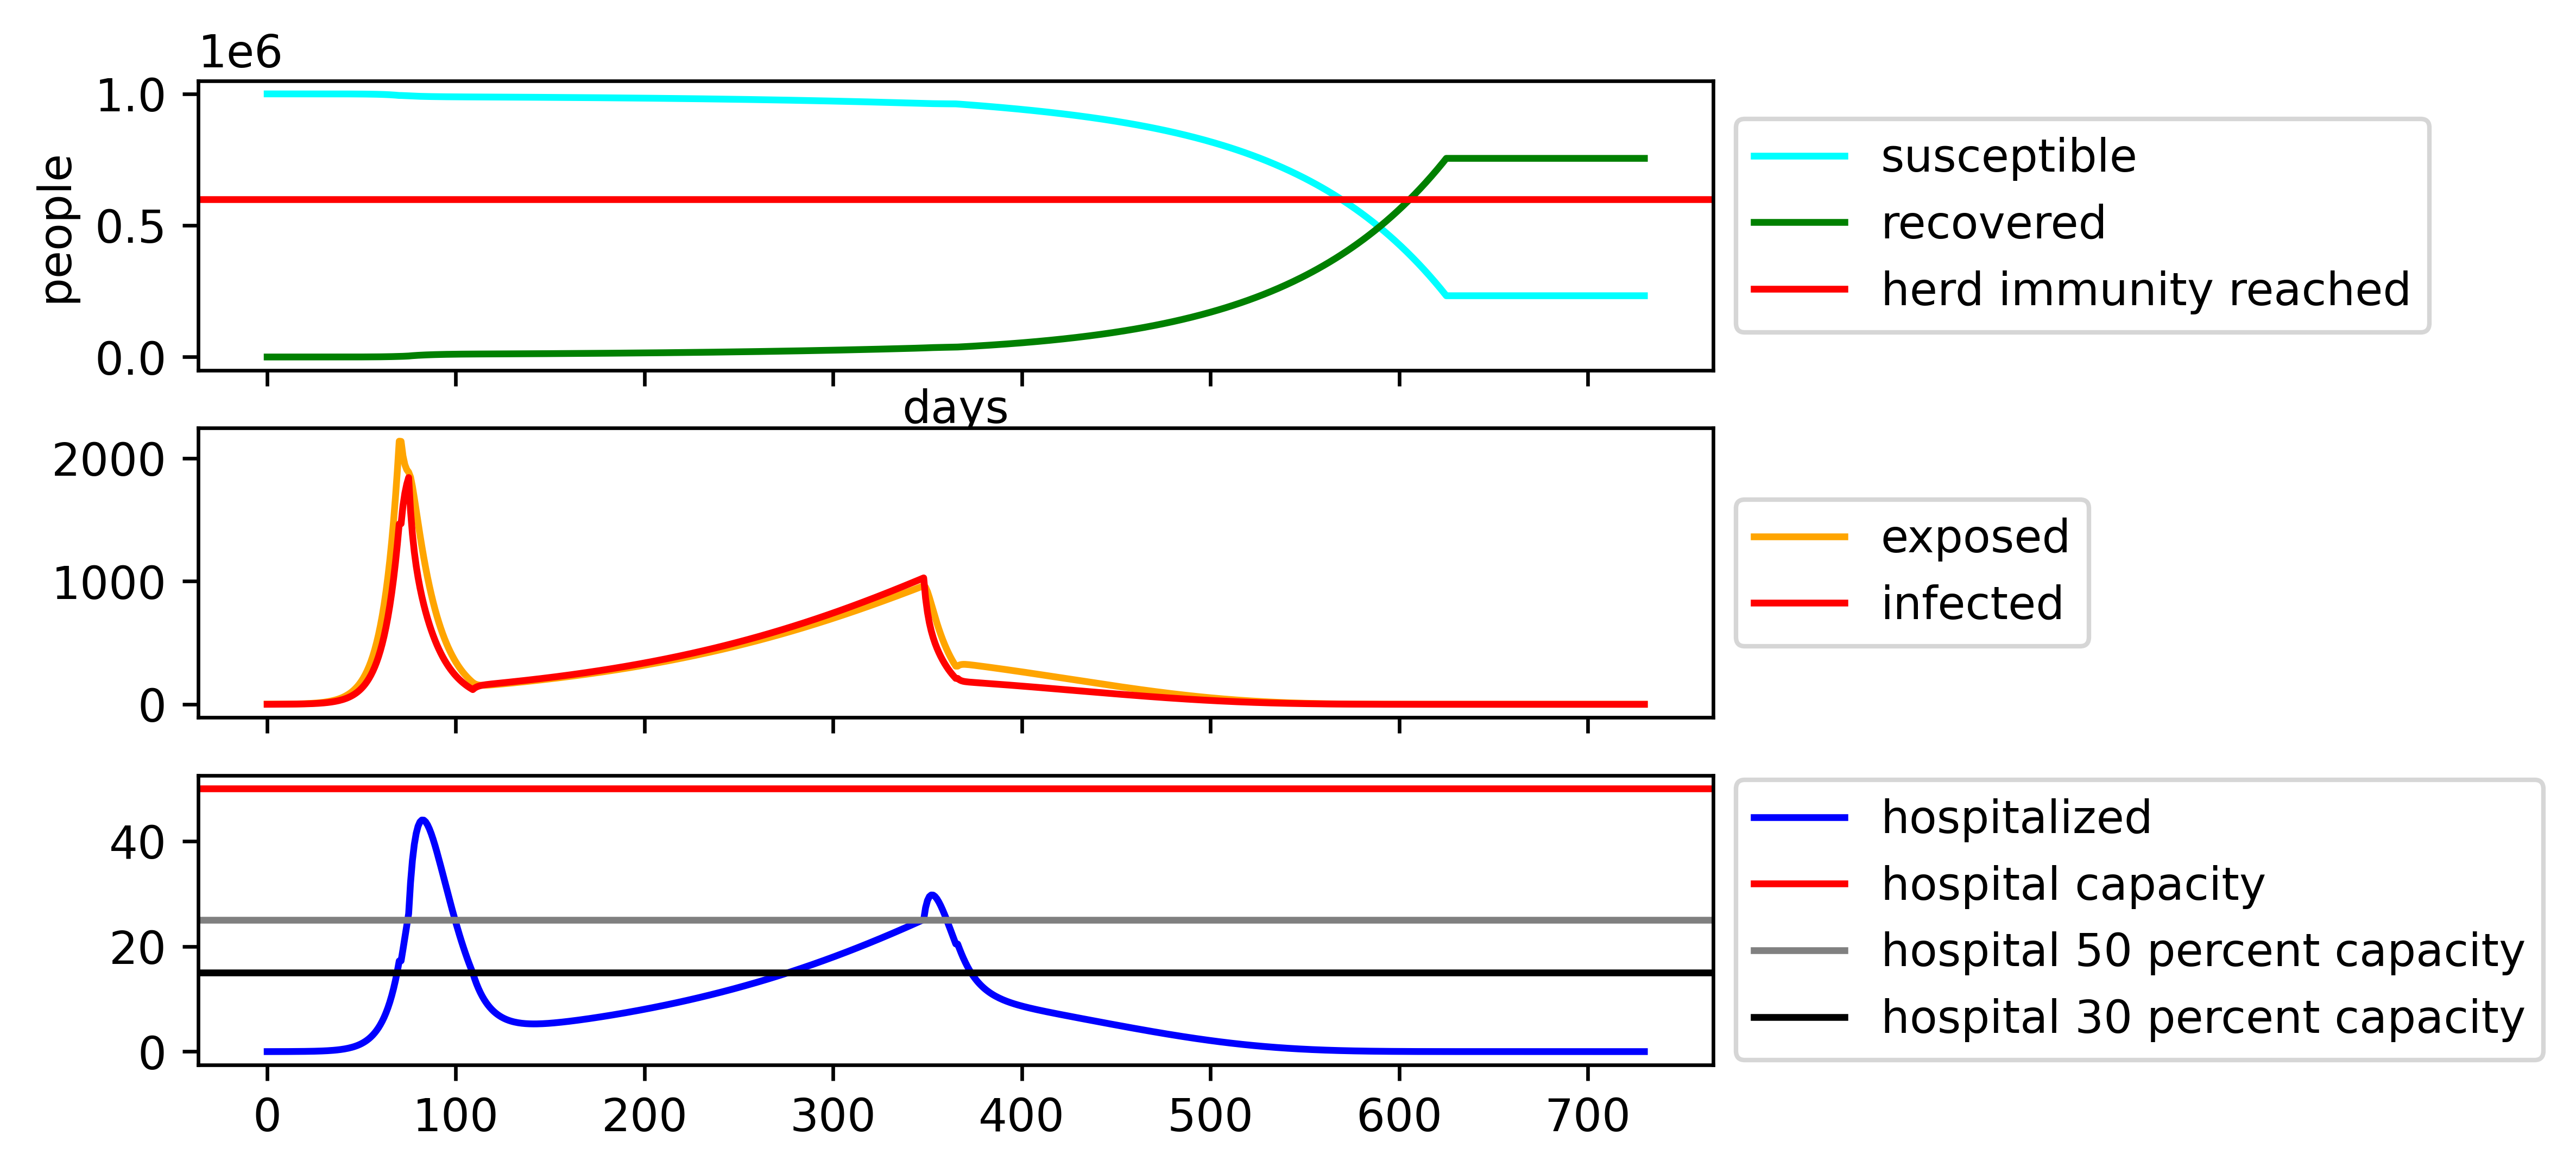

In [214]:
S0 =[999999.]
E0 =[1.]
IR0=[0.]
IH0=[0.]
R0= [0.]
H0= [0.]
# history of the first 70 days
S,E,IR,IH,R,H=run_simulation_epidemic(S0,E0,IR0,IH0,R0,H0,Tmax=70)
# use the past history as input, apply some measure for a month, and append new history to past one
S,E,IR,IH,R,H=run_simulation_epidemic_CSP(S,E,IR,IH,R,H,Tmax=295)
S,E,IR,IH,R,H=run_simulation_epidemic_vax(S,E,IR,IH,R,H,Tmax=365)
plot_epidemic(S,E,IR,IH,R,H)

Note that extensive contact tracing is a very powerful measure, but not all countries have the capacity or willingness to adopt it, so it can be useful to also consider a scenario where contact tracing is simply not possible, and the only measures that can be taken are social distancing and personal protection.

Consider the following question: how long would it take to reach heard immunity for different kind of measures or no measures at all? Is it really a sensible approach to try to reach herd immunity as soon as possible to stop the epidemic?  

As an extra point, you may use your model to discuss the positive effect of vaccines. You may model this by assuming that when a susceptible person receives a vaccine, it suddenly switches to be recovered, so that it can no longer be infected.  
In practive, for example, when 50% of the population suddenly receives a vaccine, we modify the population variables in our simulation only once changing half of the susceptible people into recovered:  
```python
S[-1]-=0.5*S[-1]
R[-1]+=0.5*S[-1]
```
Then, we continue our simulation as normal. Note that this assumes that all vaccinations occur at a specific day, while in reality vaccinating a significant portion of the population may take several months. Also, this approach assumes that vaccines are 100% effective, while in reality they may be around 90% at best, and their effect also tends to wane over time due to a decrease in antibody levels and viral evolution...  
Use this apprach to discuss the question: how many people need to be vaccinated if we want to control the epidemic while lifting all the restrictions?  

## On the final presentation

You should present the results of your analysis in a ~15 minutes powerpoint presentation. The presentation will be a useful practice for the final evaluation of the course.

It should cover the following points:
- An introduction to the problem: design measures to suppress epidemic in the considered region to maintain low hospitalizations.
- The description of the model: what are its assumptions and limitations.
- The code: what it does, the algorithm used, input, and output.
- Your results: which measures work, what did we learn from it (for example: the importance of acting quickly, the risk of a second wave of infections).
- Anything else that you find interesting and relevant to the topic, even if not strictly about simulations.

The presentation should be in English (but note that the English level itself is not considered for the evaluation, so do not be afraid to speak in English).